In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
def make_train_test(DIR="../input/"):
    train=pd.read_csv(DIR+"/train2_2016_2017_withy.csv",index_col=0)
    test=pd.read_csv(DIR+"/test2_2016_2017_withy.csv",index_col=0)    
    labels=train['logerror']
    train=train.drop("logerror",axis=1)
    test=test.drop("logerror",axis=1)
    assert (train.columns==test.columns).all()
    return train.astype(np.float32),labels.astype(np.float32),test.astype(np.float32)

In [3]:
%time train,labels,test=make_train_test()
train.shape,labels.shape,test.shape

CPU times: user 1min 8s, sys: 17.3 s, total: 1min 25s
Wall time: 1min 25s


((167888, 112), (167888,), (5970434, 112))

In [4]:
train.values.nbytes/1024**2.,test.values.nbytes/1024.**2

(71.7294921875, 2550.8446044921875)

In [5]:
set(train['year']),set(train['month'])

({2016.0, 2017.0},
 {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0})

In [6]:
test['year'].value_counts(),test['month'].value_counts()

(Series([], Name: year, dtype: int64), Series([], Name: month, dtype: int64))

In [7]:
test['year']=test.index.map( lambda u: 2016 if u%10==6 else 2017).astype(np.float32)

In [8]:
test['year'].value_counts(),test['month'].value_counts()

(2017.0    2985217
 2016.0    2985217
 Name: year, dtype: int64, Series([], Name: month, dtype: int64))

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
import cPickle as pickle
import socket

In [10]:
def get_module():
    modulename='xgboost'
    if modulename not in sys.modules:
        sys.path.insert(0, '/home/spark/software/lz/tmp/a/z/third/xgboost/python-package/build/lib/')        
        import xgboost
    if modulename not in sys.modules:
        raise Exception("module not found")
    m=sys.modules[modulename]
    print m.__version__
    assert m.__file__.startswith("/home/spark/software/lz/tmp/a/z/third"), m.__file__
    return  m,socket.gethostname()
        

In [11]:
files='/tmp/c/xgb_l1f0 /tmp/c/xgb_l1f1 /tmp/c/xgb_l1f2 /tmp/c/xgb_l1f4 /tmp/c/xgb_l1f6 /tmp/c/xgb_l1f7'.split(" ")
files

['/tmp/c/xgb_l1f0',
 '/tmp/c/xgb_l1f1',
 '/tmp/c/xgb_l1f2',
 '/tmp/c/xgb_l1f4',
 '/tmp/c/xgb_l1f6',
 '/tmp/c/xgb_l1f7']

In [12]:
import findspark
findspark.init()

In [13]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',1)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','5') 
conf.set('spark.executor.memory','45G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local")

In [14]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

In [15]:
len(test.values),test.values.nbytes/1024.0**2

(5970434, 2550.8446044921875)

In [16]:
tests=[test.iloc[:1000000],test.iloc[1000000:2000000],
       test.iloc[2000000:3000000],test.iloc[3000000:4000000]
       ,test.iloc[4000000:5000000],test.iloc[5000000:6000000]]

In [17]:
np.sum([len(u) for u in tests]),[u.values.nbytes/1024.**2 for u in tests]

(5970434,
 [427.24609375,
  427.24609375,
  427.24609375,
  427.24609375,
  427.24609375,
  414.6141357421875])

In [18]:
data=sc.broadcast(tests[0][:100])

In [45]:
def load_models(filename):
    while 1:
        tmp=sc.parallelize(range(200),200)
        ips=tmp.map(lambda u:  get_module()[1]).collect()
        print len(set(ips)),
        if len(set(ips))==19:
            break
    models=sc.pickleFile(filename).map(lambda u: (u[0],u[1],pickle.dumps(u[2]))).cache()
    print models.count()
    return models

In [64]:
filename=files[5]

In [65]:
models=load_models(filename)

19 95


In [66]:
scores=models.map(lambda u: u[1]).collect()

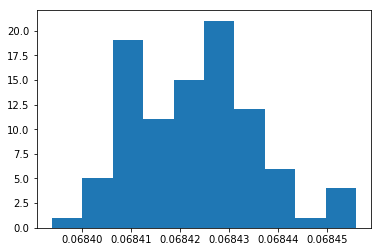

In [67]:
plt.hist(scores);

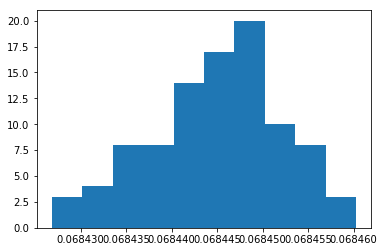

In [55]:
plt.hist(scores);

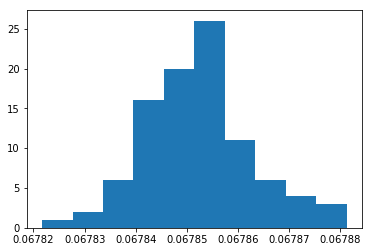

In [50]:
plt.hist(scores);

In [68]:
def run_once(models_str):
    xgb=get_module()[0]
    d_test = xgb.DMatrix(data.value.values)
    pred=0
    models=pickle.loads(models_str)
    for m in models:
        pred=pred+m.predict(d_test)
    pred=pred/float(len(models))
    return pred


In [69]:
preds=models.map(lambda u: run_once(u[2])).collect()

In [60]:
plt.hist([u[1] for u in preds]);

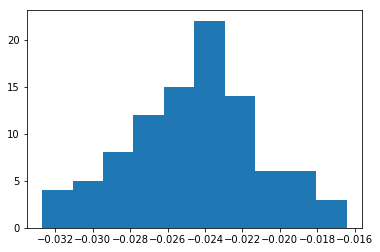

In [39]:
plt.hist([u[1] for u in preds]);

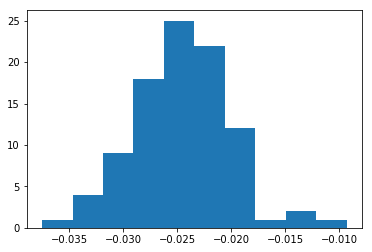

In [70]:
plt.hist([u[1] for u in preds]);

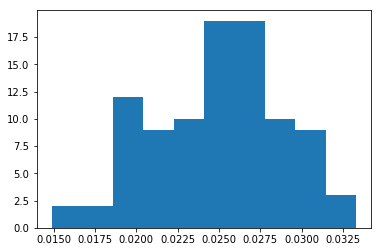

In [62]:
plt.hist([u[10] for u in preds]);

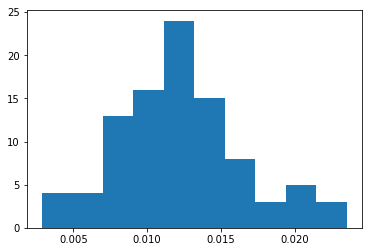

In [51]:
plt.hist([u[10] for u in preds]);

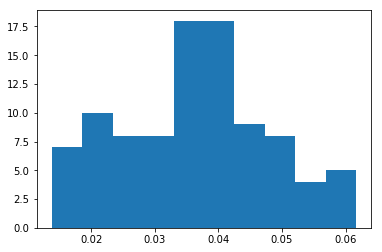

In [71]:
plt.hist([u[10] for u in preds]);

In [45]:
a[0]

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 1,
 'objective': 'reg:l1f0',
 'subsample': 0.8}

In [46]:
a[1]

0.067842163

In [48]:
len(a[2]),type(a[2][0])

(10, xgboost.core.Booster)

In [19]:
N=19*5
#paramlist=list(params.values())*N
#print len(paramlist)
for param in list_params:
    filename="/tmp/c/xgb_"+param['objective'].split(":")[-1]
    !hadoop fs -rmr {filename}
    print filename 
    sc.parallelize(range(N),N).map(lambda u: run_once(param,data.value[0],data.value[1])).saveAsPickleFile(filename)
    #.saveAsTextFile(filename)
#     all_models.append((param,results))
#     pickle.dump(all_models,open('xg_models.pkl','wb'))

rmr: DEPRECATED: Please use 'rm -r' instead.
17/10/08 04:43:27 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/c/xgb_l1f0
/tmp/c/xgb_l1f0
rmr: DEPRECATED: Please use 'rm -r' instead.
17/10/08 04:50:59 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/c/xgb_l1f1
/tmp/c/xgb_l1f1
rmr: DEPRECATED: Please use 'rm -r' instead.
17/10/08 04:58:39 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/c/xgb_l1f2
/tmp/c/xgb_l1f2
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/c/xgb_l1f4': No such file or directory
/tmp/c/xgb_l1f4
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/c/xgb_l1f6': No such file or directory
/tmp/c/xgb_l1f6
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/c/xgb_l1f7': No such file or directory
/tmp/c/xgb_l1f7


In [20]:
sc.stop()